In [1]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False
if IN_COLAB:
  ! git clone https://github.com/pesvut/opt-tools.git && mv ./opt-tools/src/*.py .
  ! pip install -q transformers datasets evaluate zstandard

In [1]:
from model import Model
from texts import prepare_pile, prepare_code
import torch

In [12]:
def prepare( dataset_name ):
    if dataset_name == 'pile':
        return prepare_pile()
    if dataset_name == 'code':
        return prepare_code()

opt = Model()

 - Registered 12 OPT Attention Layers


In [24]:
from random import sample
from tqdm import tqdm

def setup_counter(ff_keys):
    shape = ff_keys.size()
    counter = []
    for i in range(shape[0]):
        counter.append( torch.zeros( shape[-1]))
    return torch.stack(counter)

def count_keys( dataset_name, limit=1000, sample_size=10000, num_samples=1, 
                check_accuracy=False, k=10, check_skips=False ):
    dataset, label, skip_eval = prepare( dataset_name )
    counters = []
    counter = None
    curr_count = 0
    with tqdm(total=sample_size*num_samples) as pbar:
        for data in dataset:
            text = data[label]
            input_ids = opt.get_ids( text, limit=limit )
            ids = input_ids.squeeze()

            # Criteria for counting the token activation
            criteria = torch.zeros_like( ids, dtype=torch.bool )

            # check if prediction is accurate enough to count
            if check_accuracy:
                residual_stream = opt.get_residual_stream( input_ids=input_ids )
                logits = opt.unembed( residual_stream[-1] )
                top_k_tokens = opt.top_k_tokens( logits, k=k ).squeeze()

                for index in range(len(ids)-1):
                    criteria[index] *= (ids[index+1] in top_k_tokens[index])

            # Choose a set of token ids to skip 
            if check_skips:
                skip_ids = set()
                for skip_string in skip_eval:
                    skip_id = int( opt.get_ids( skip_string ).squeeze()[-1] )
                    skip_ids.add( skip_id )

                for index in range(len(ids)-1):
                    criteria[index] *= (ids[index+1] in skip_ids)
                
            num_valid_tokens = criteria.sum()
            curr_count += num_valid_tokens

            ff_keys = opt.get_ff_key_activations(input_ids=input_ids)
            if counter is None:
                
                counter = setup_counter(ff_keys)
            for layer_index, layer in enumerate(ff_keys):
                for token_index, key_activation in enumerate(layer):
                    if not criteria[token_index]:
                        continue
                    counter[layer_index] += ( key_activation != 0 )


            pbar.update( num_valid_tokens ) 
            if curr_count > sample_size:
                counter = counter / curr_count
                counters.append( counter )
                print( f'sample {len(counters)}: {curr_count}' )
                
                counter = setup_counter(ff_keys)
                curr_count = 0
            
            if len( counters ) >= num_samples:
                break
    
    return torch.stack( counters )

def acc_str( acc, pred ):
    return f"{100*round(acc/pred, 2)}% - ( {acc}/{pred} )"

def evaluate( dataset_name, limit : int = 1e6 ):
    dataset, label, skip_eval = prepare( dataset_name )
    out = opt.evaluate_dataset( dataset, token_limit=1000, k=1,
        start_index=1, stopping_index=limit, skip_eval=skip_eval,
        dataset_text_label=label, count_tokens=False )
    print( f'{dataset_name} w/ skip:', 
        acc_str(out['num_skip_accurate'], out['num_skip_predictions']) )
    print( f'{dataset_name} no skip:',
        acc_str( out['num_accurate'], out['num_predictions']) )
    return out

def evaluate_all( limit: int = 1e5 ):
    pile_out = evaluate( 'pile', limit )

    code_out = evaluate( 'code', limit )

In [4]:
evaluate_all( 10000 )

No config specified, defaulting to: the_pile/all
accuracy 38.7% (curr 66.9%): : 10381it [00:55, 186.69it/s]                        


pile w/ skip: 39.0% - ( 4022/10381 )
pile no skip: 49.0% - ( 8109/16445 )


Using custom data configuration codeparrot--codeparrot-clean-valid-826c6fd8b27e5523
Found cached dataset json (/config/.cache/huggingface/datasets/codeparrot___json/codeparrot--codeparrot-clean-valid-826c6fd8b27e5523/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab)


  0%|          | 0/1 [00:00<?, ?it/s]

accuracy 42.9% (curr 31.7%): : 10209it [01:36, 106.26it/s]                        

code w/ skip: 43.0% - ( 4381/10209 )
code no skip: 60.0% - ( 12974/21528 )


for 1e4 steps
```
pile w/ skip: 39.0% - ( 4022/10381 )
pile no skip: 49.0% - ( 8109/16445 )

code w/ skip: 43.0% - ( 4381/10209 )
code no skip: 60.0% - ( 12974/21528)
```

for 1e4 steps
```
pile w/ skip: 39.0% - ( 4022/10381 )
pile no skip: 49.0% - ( 8109/16445 )

code w/ skip: 43.0% - ( 4381/10209 )
code no skip: 60.0% - ( 12974/21528)
```

In [25]:
pile_counters = count_keys( 'pile', sample_size=5e4, num_samples=1 )
print( pile_counters.size() )

code_counters = count_keys( 'code', sample_size=5e4, num_samples=1 )
print( code_counters.size() )

No config specified, defaulting to: the_pile/all
66856it [13:58, 79.72it/s]                              


sample 1: 50377
torch.Size([1, 11, 3072])


Using custom data configuration codeparrot--codeparrot-clean-valid-826c6fd8b27e5523
Found cached dataset json (/config/.cache/huggingface/datasets/codeparrot___json/codeparrot--codeparrot-clean-valid-826c6fd8b27e5523/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab)


  0%|          | 0/1 [00:00<?, ?it/s]

62668it [12:17, 84.94it/s]                              

sample 1: 50169
torch.Size([1, 11, 3072])


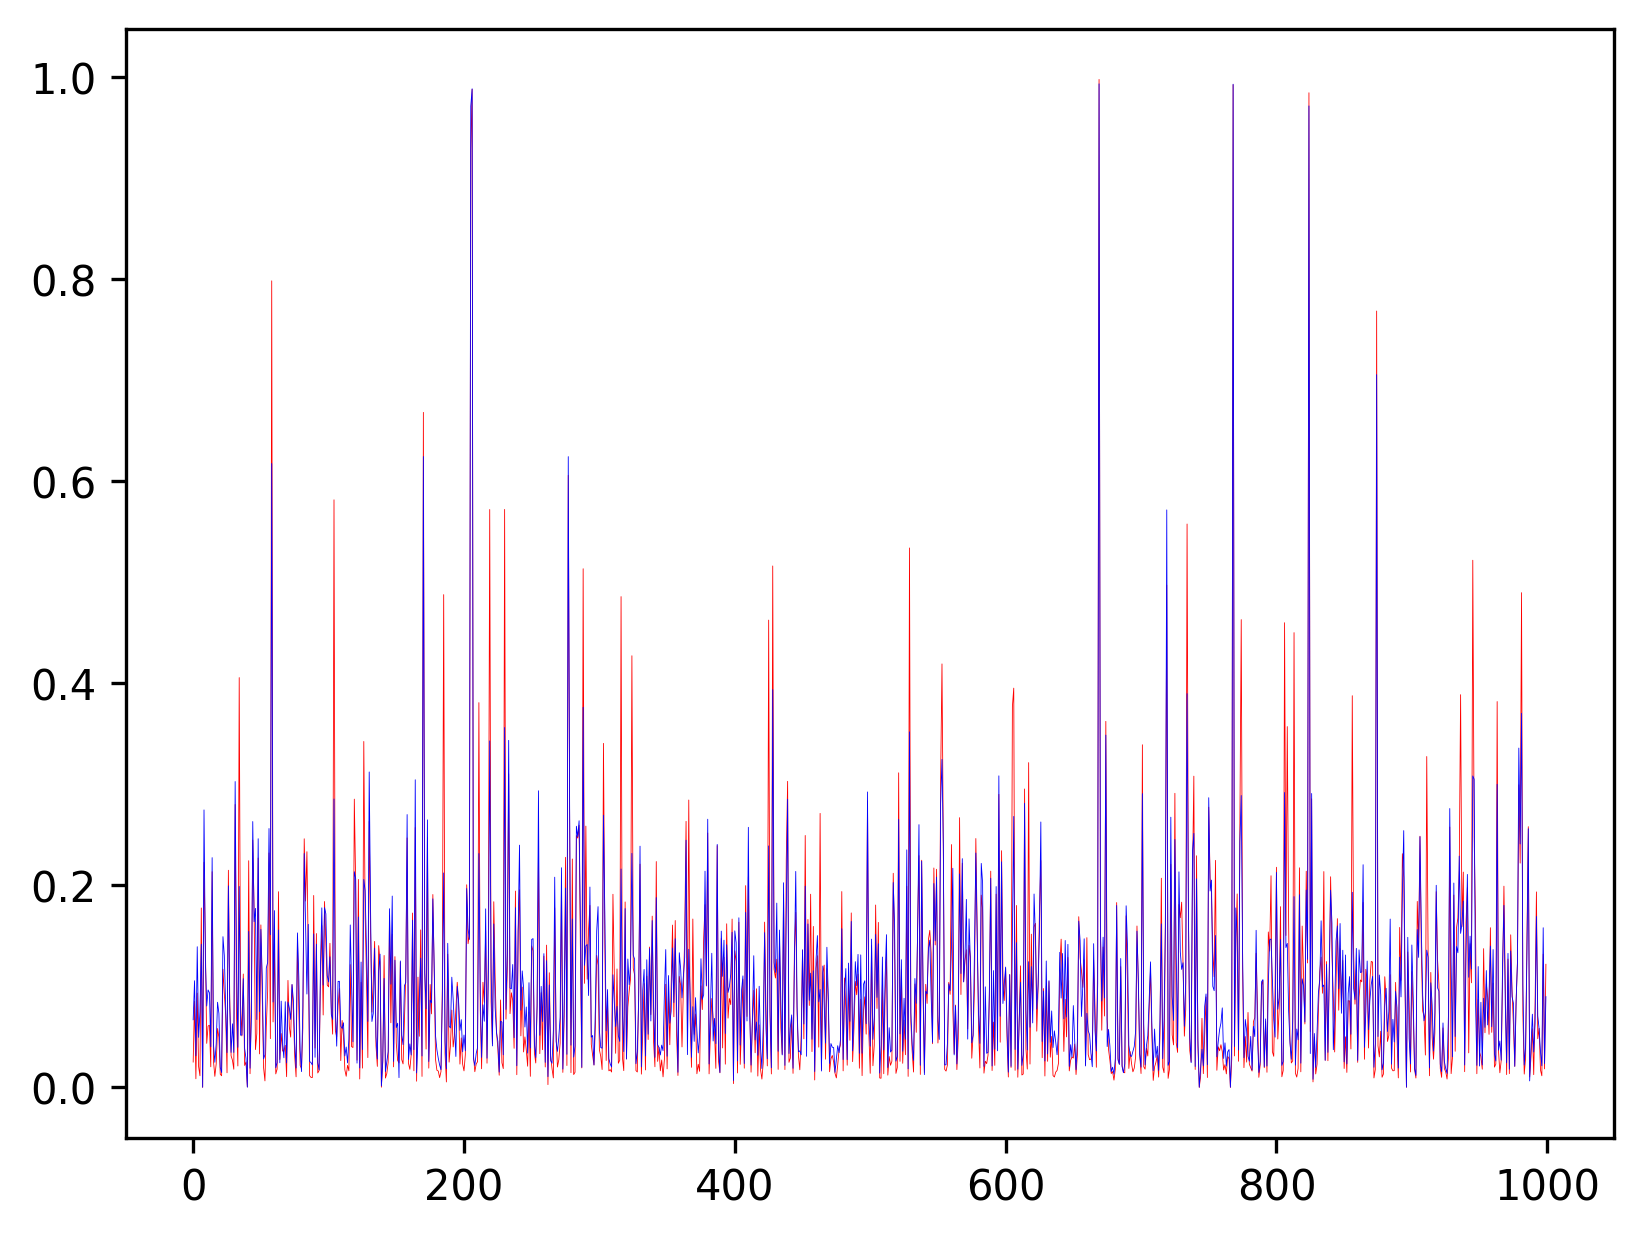

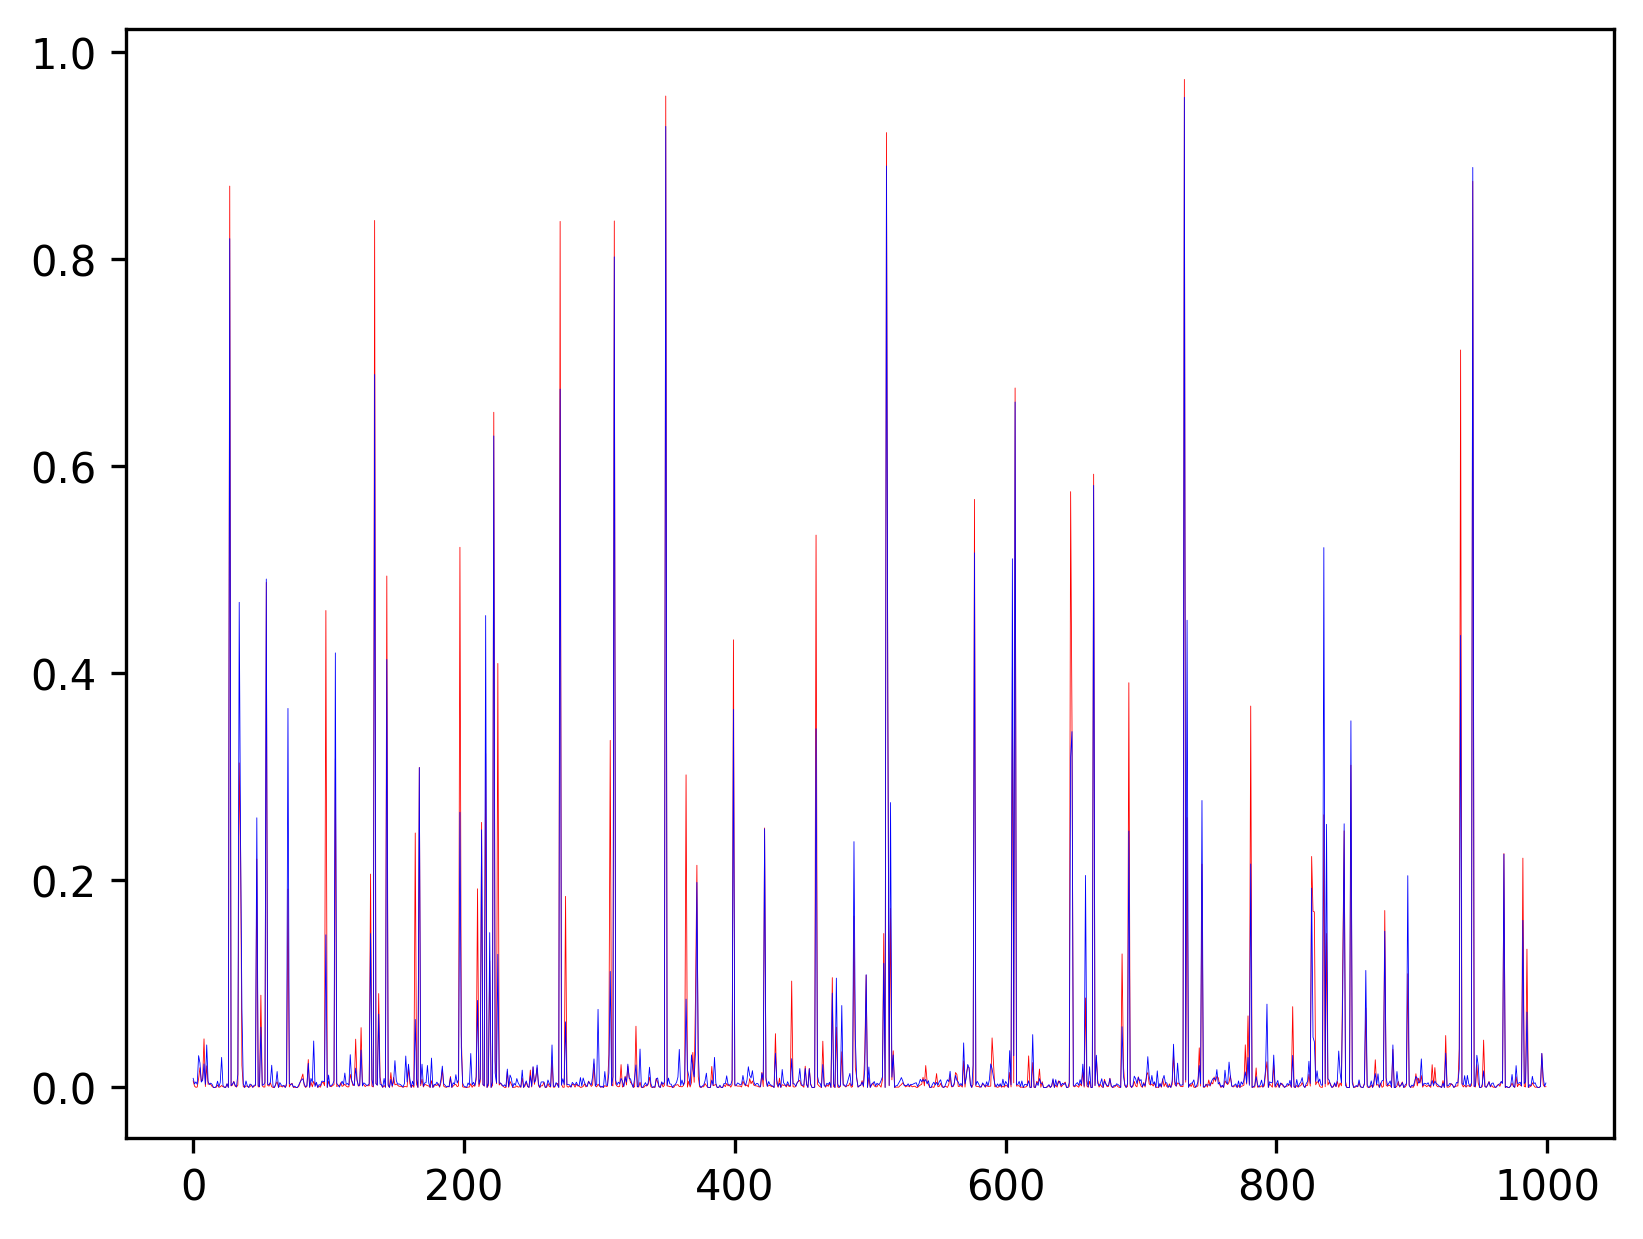

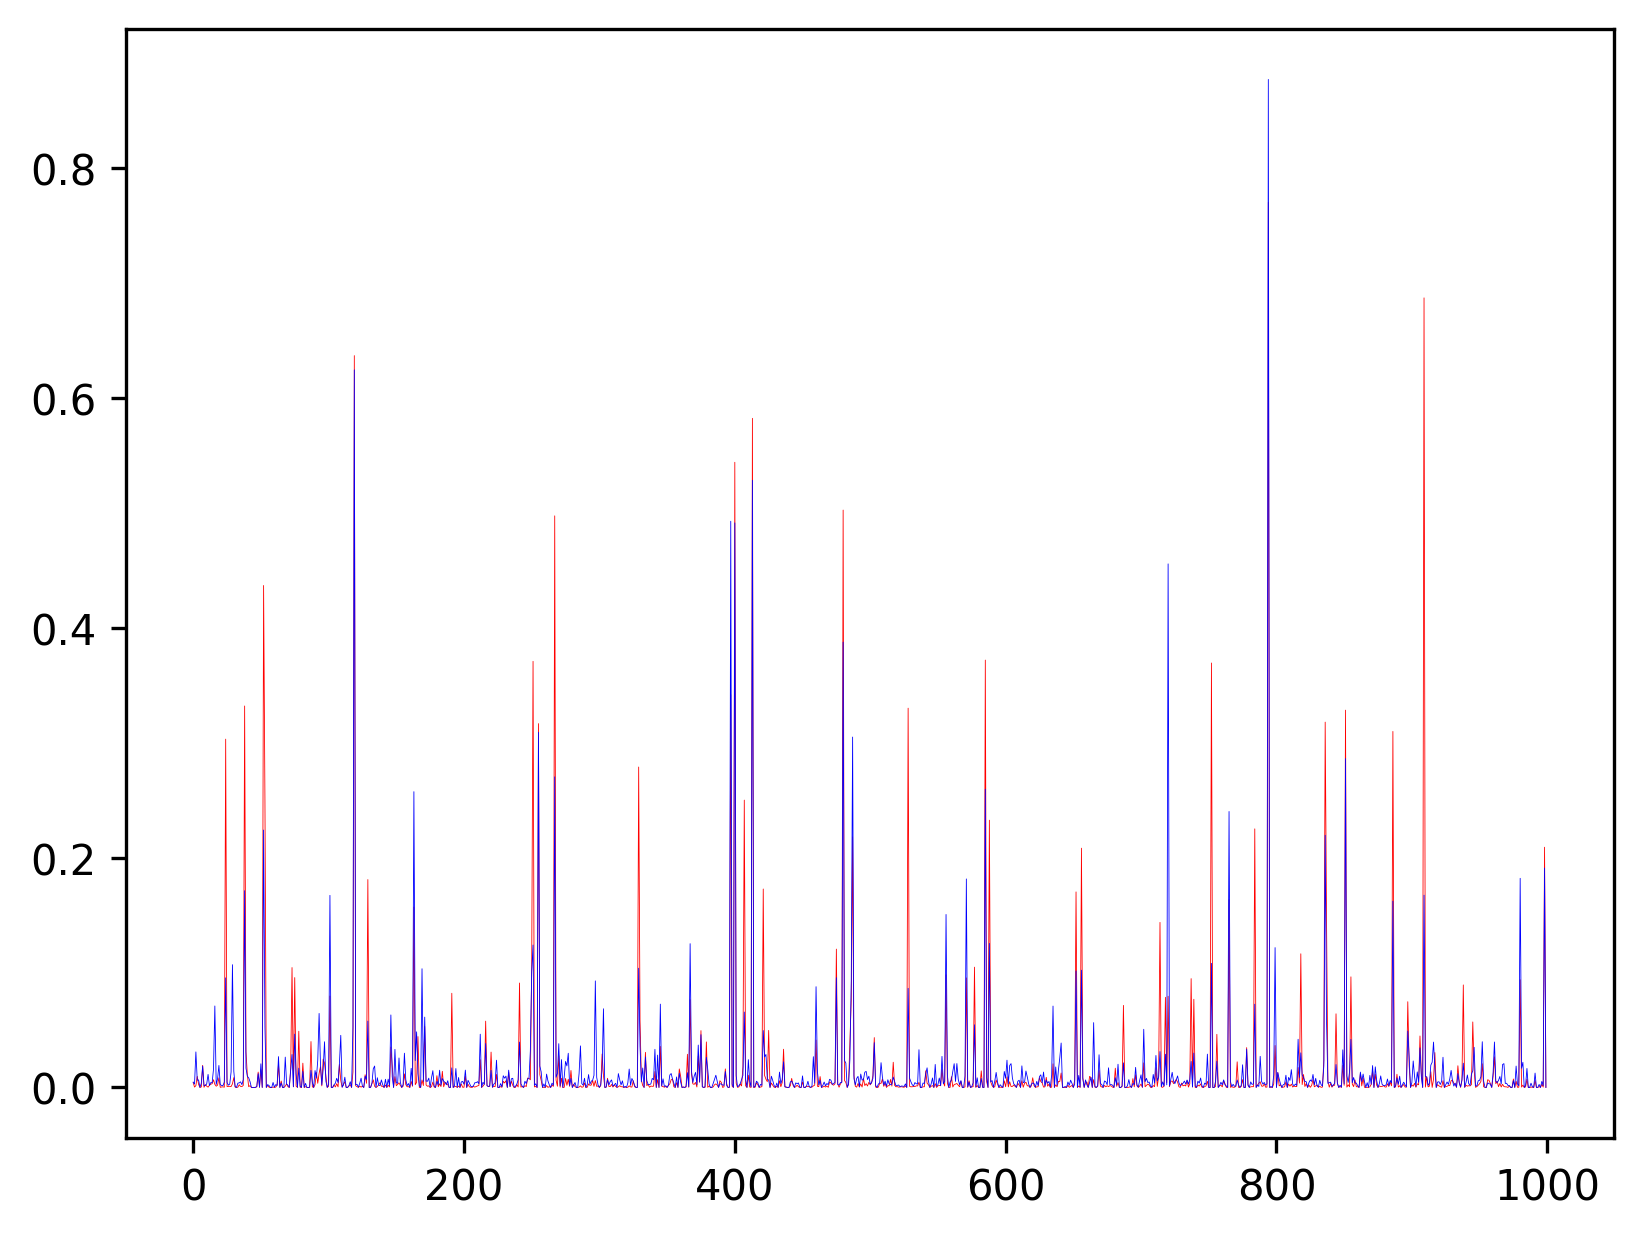

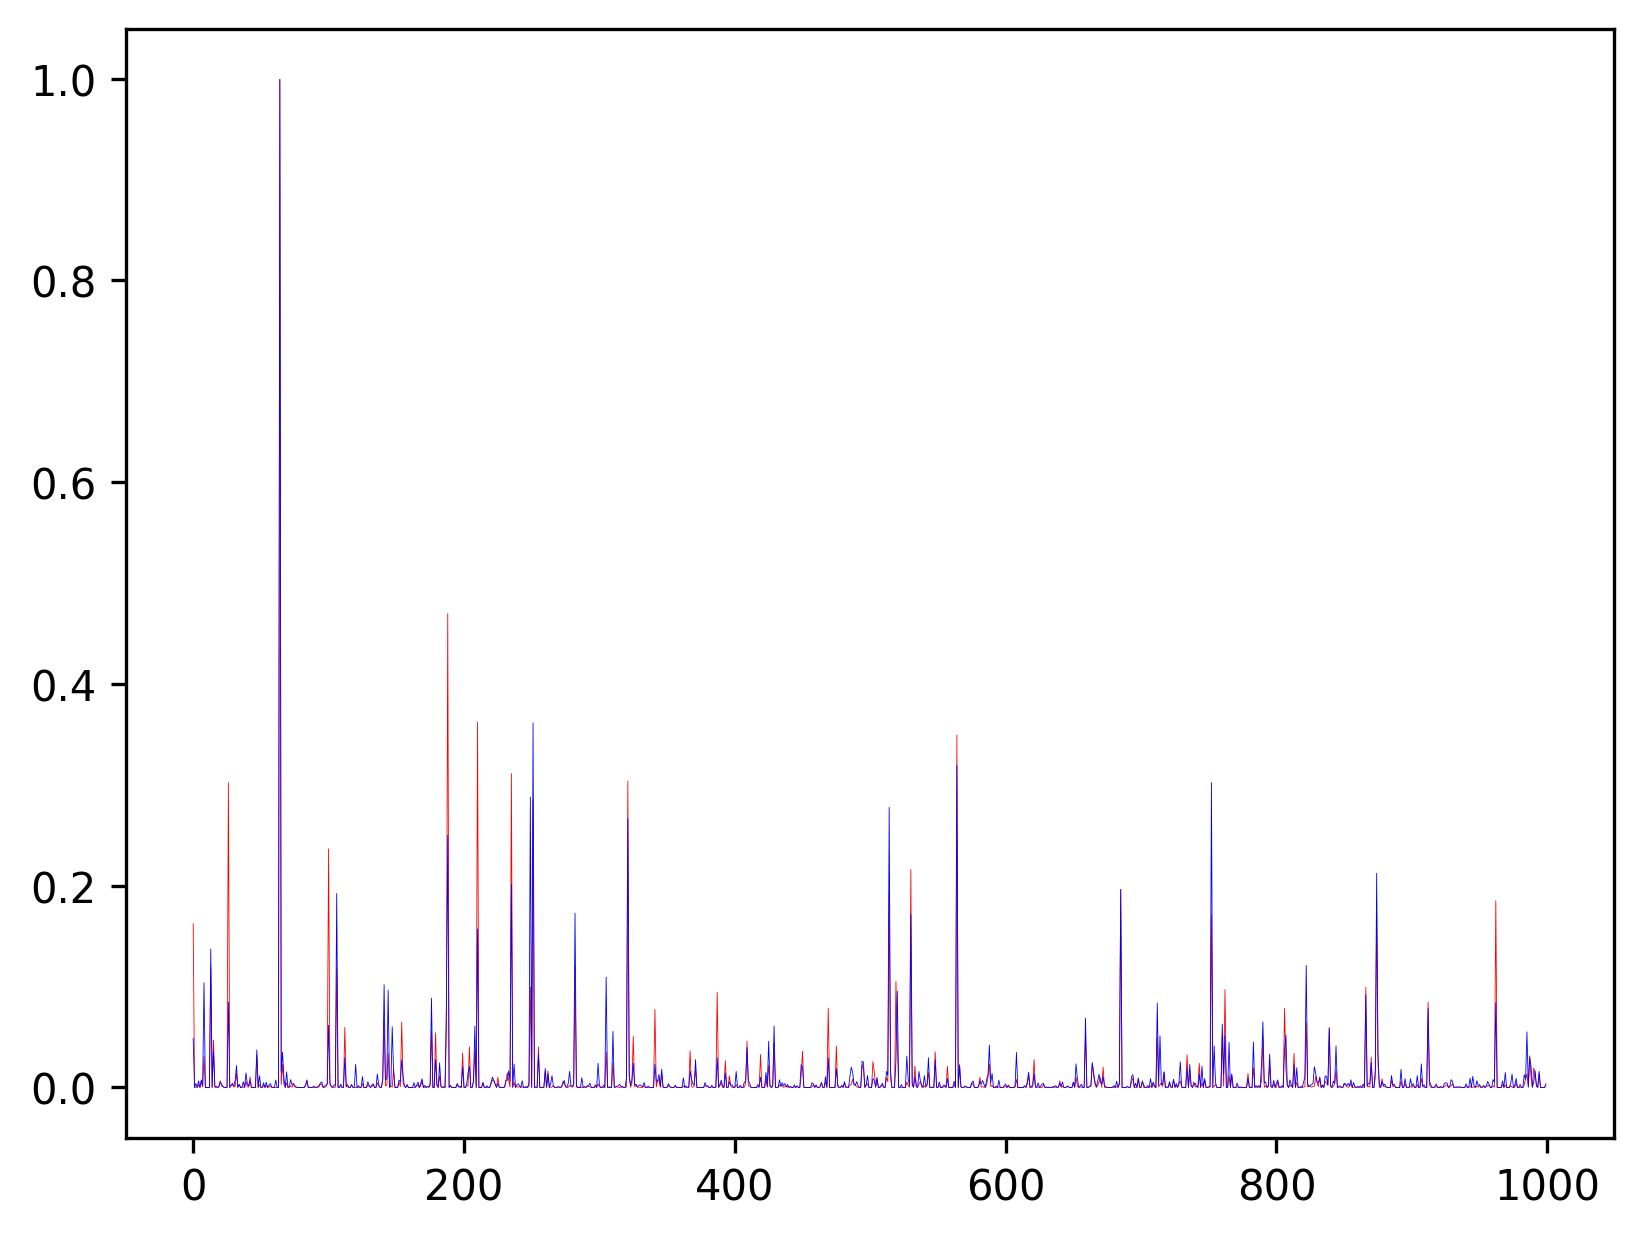

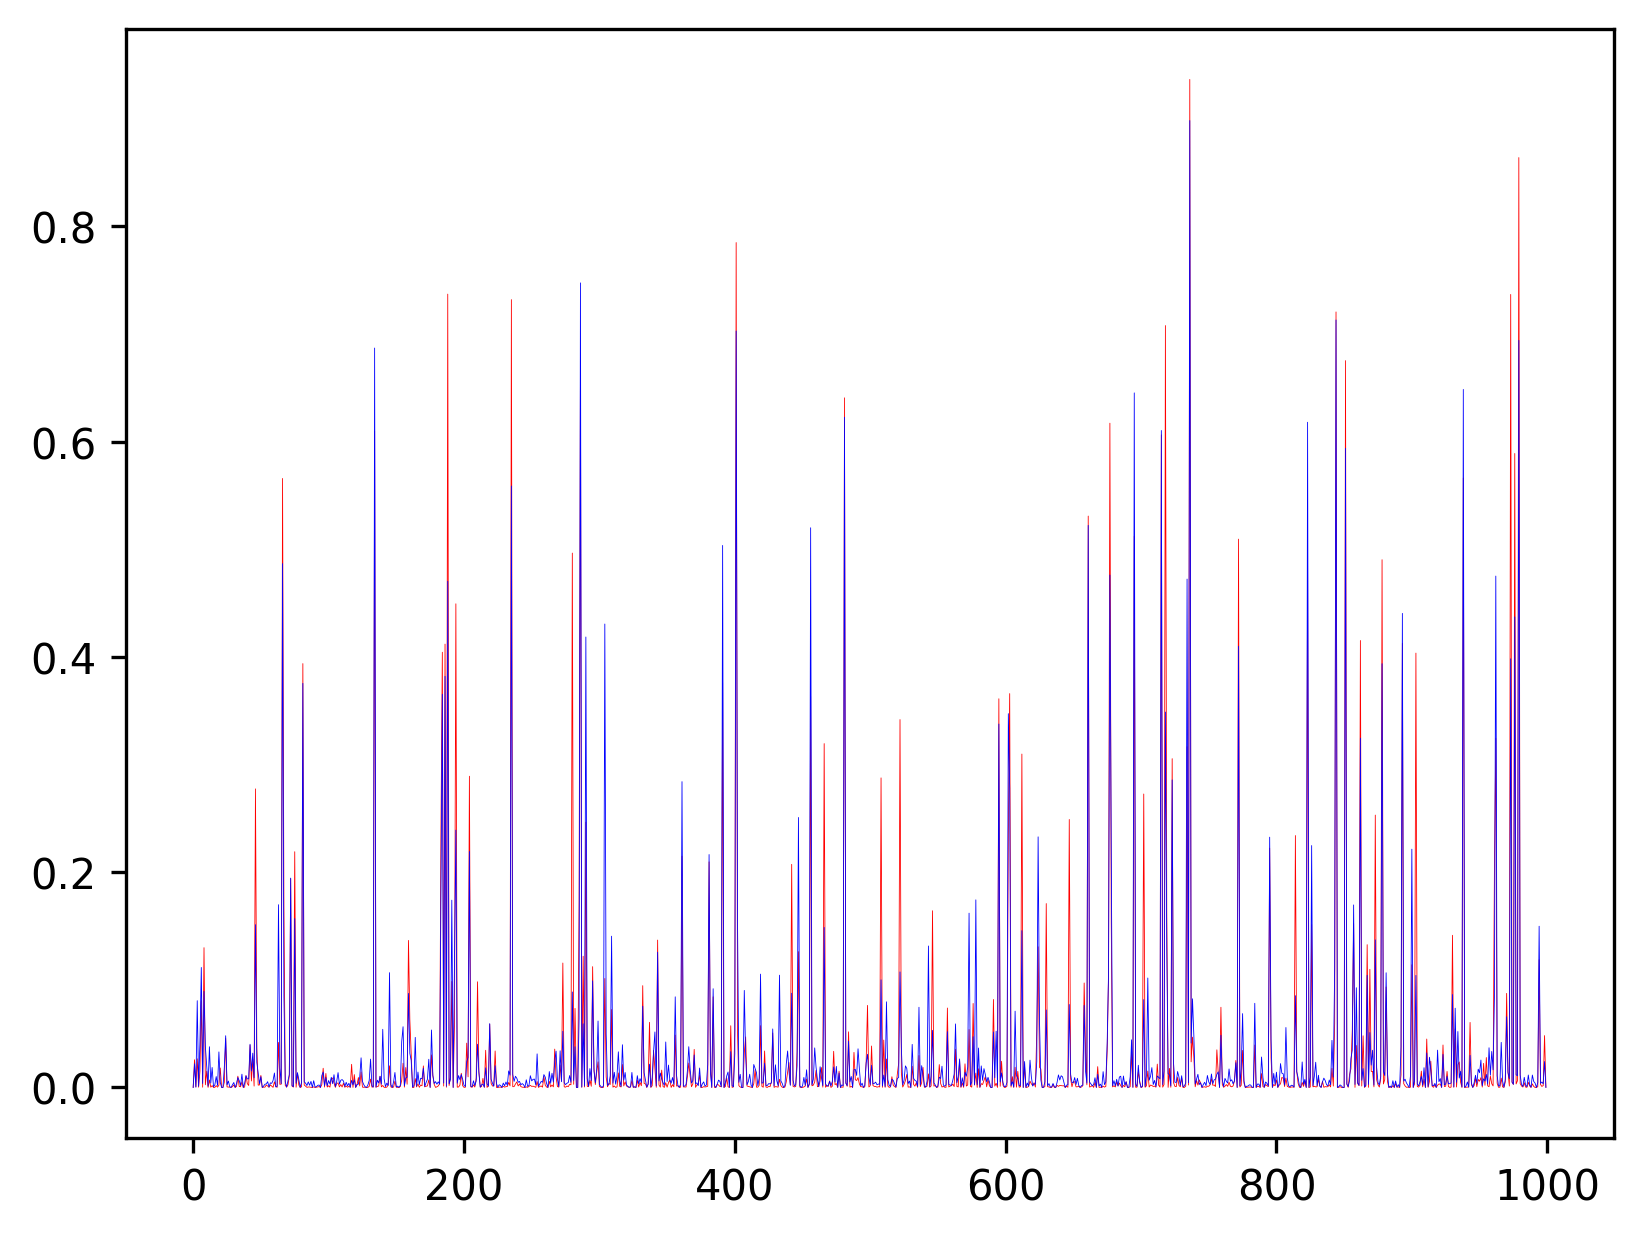

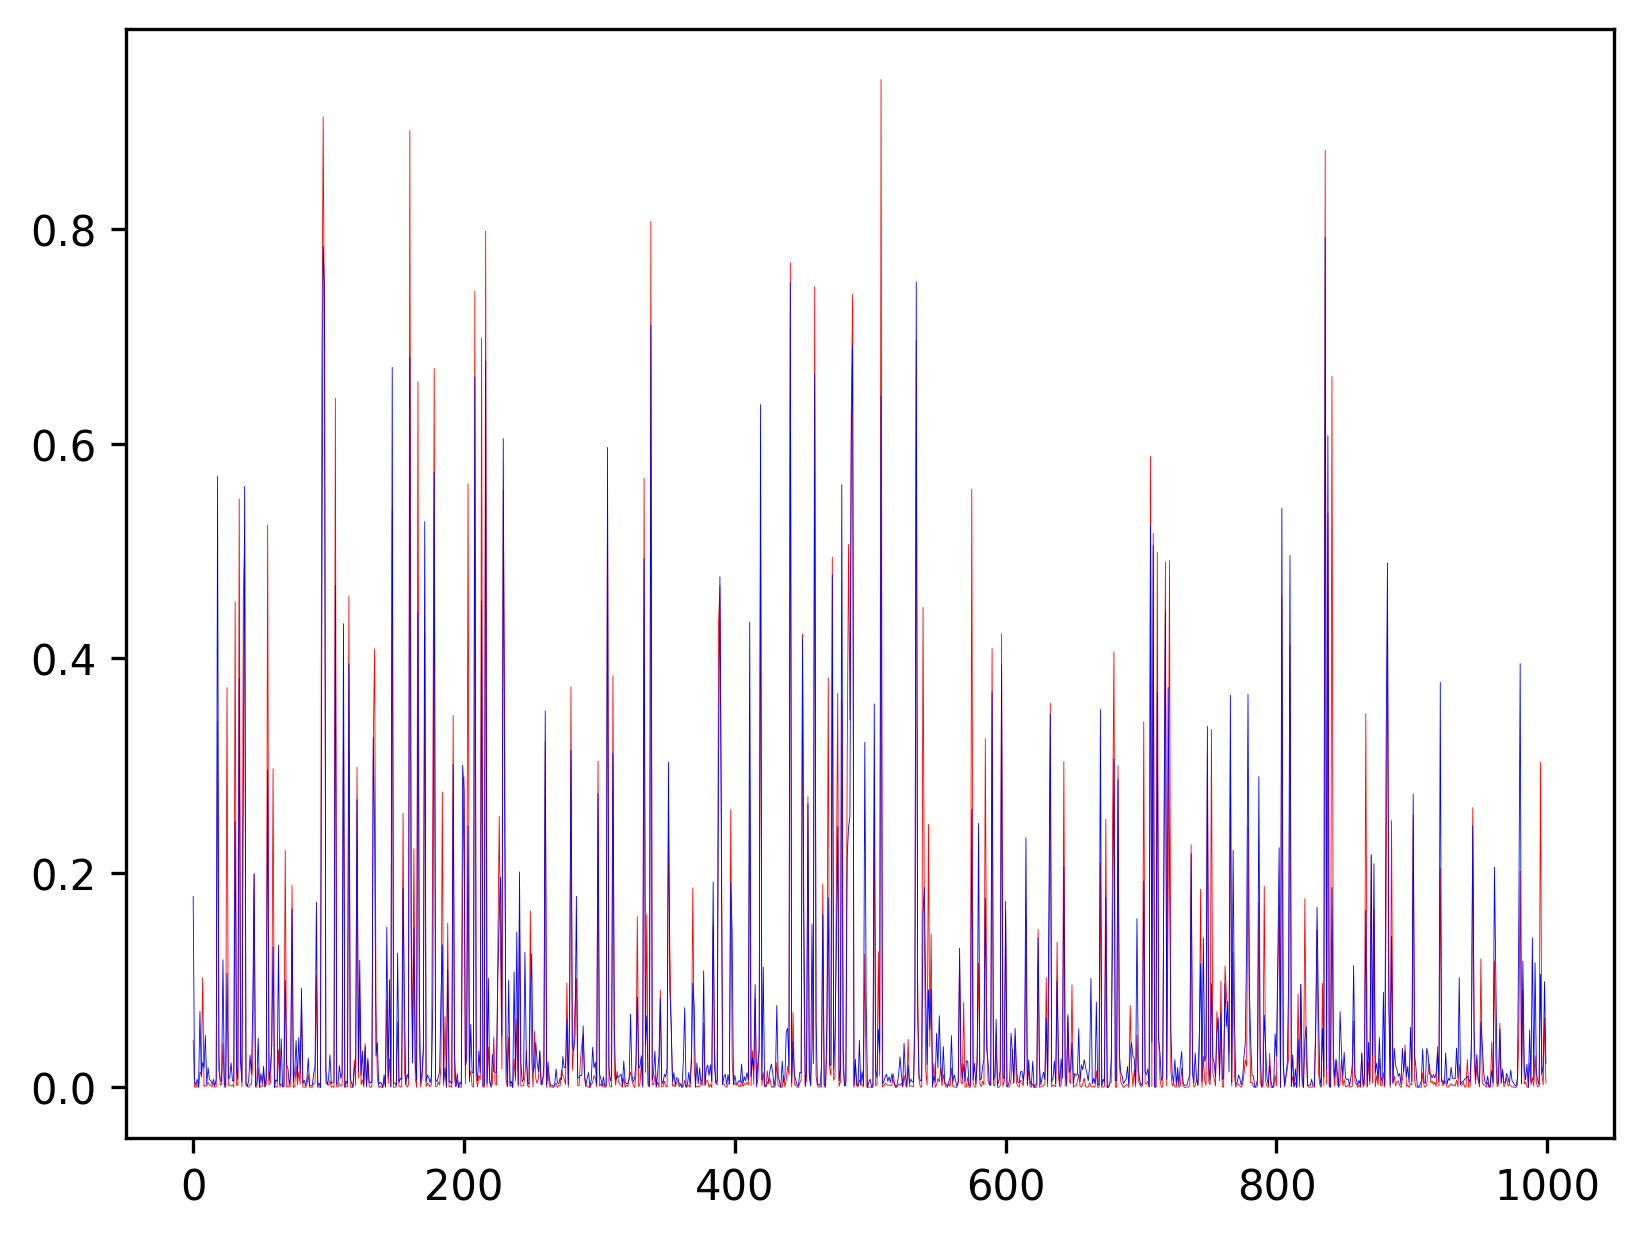

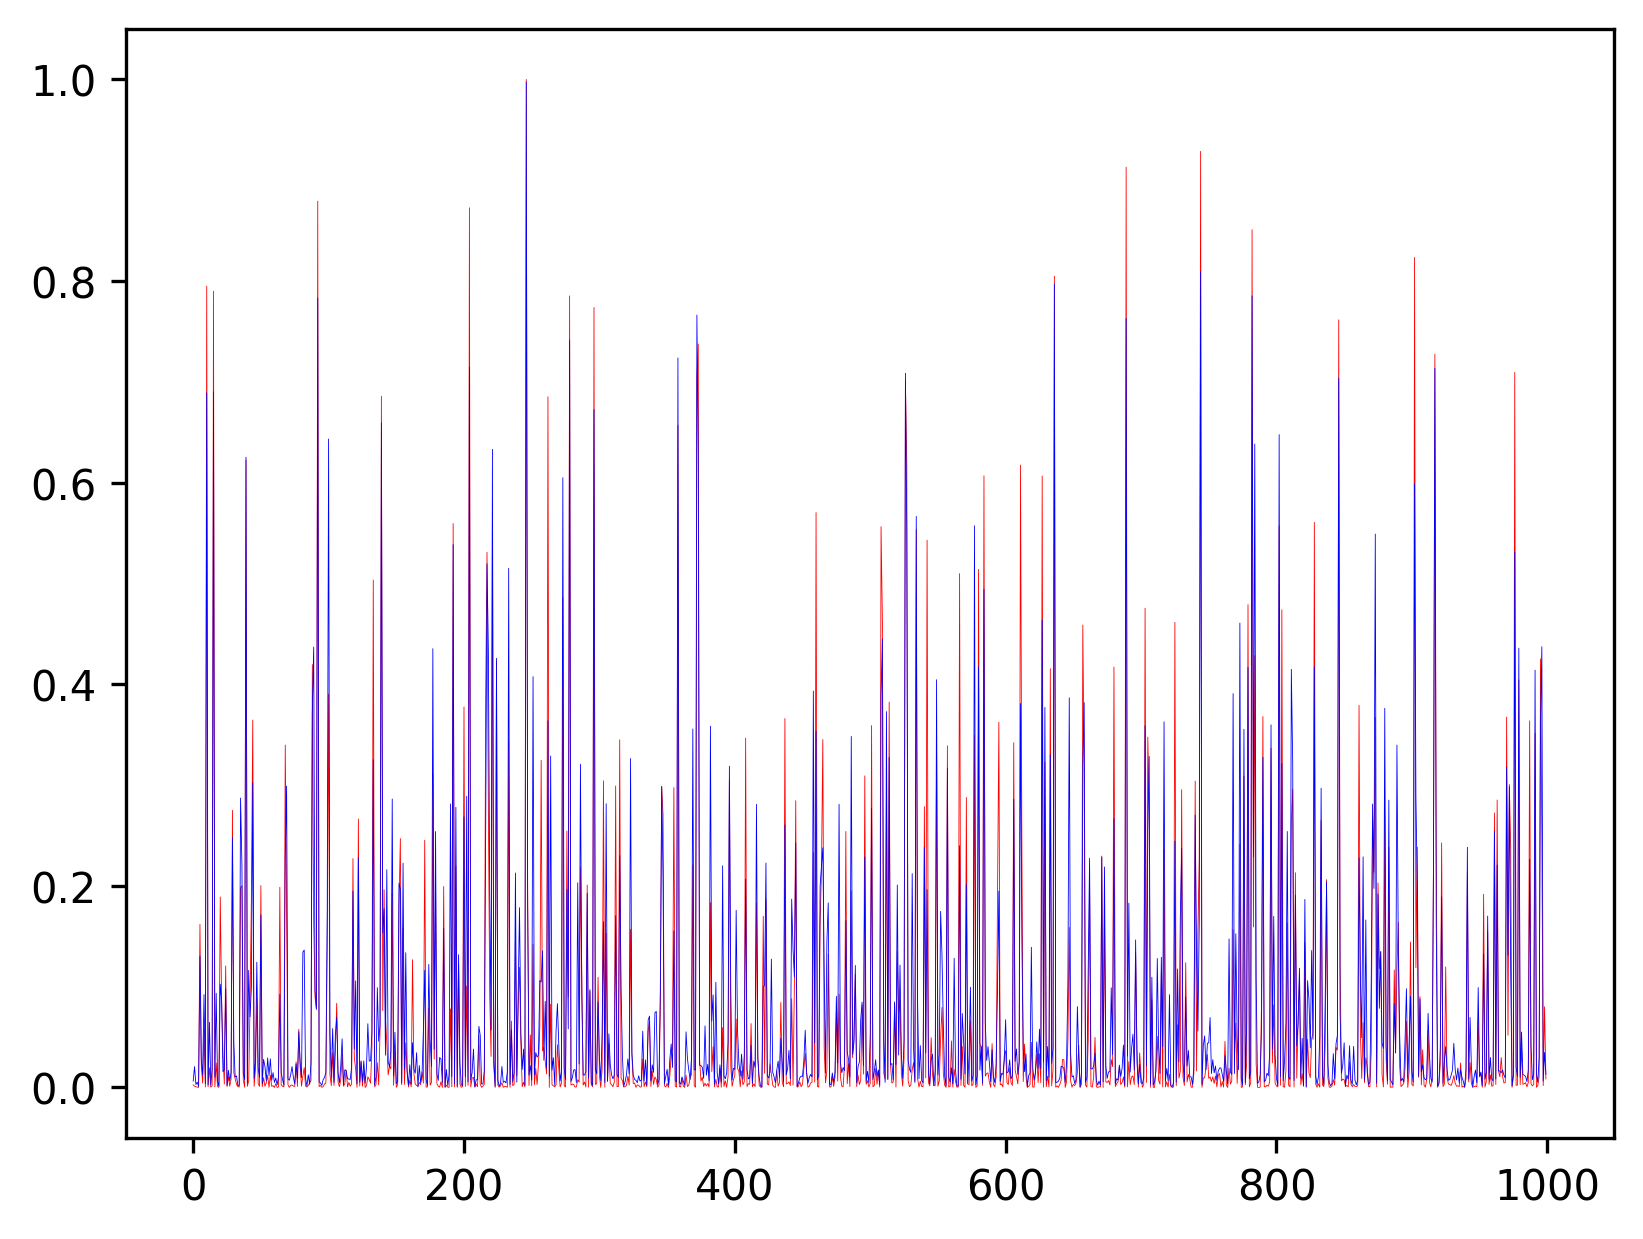

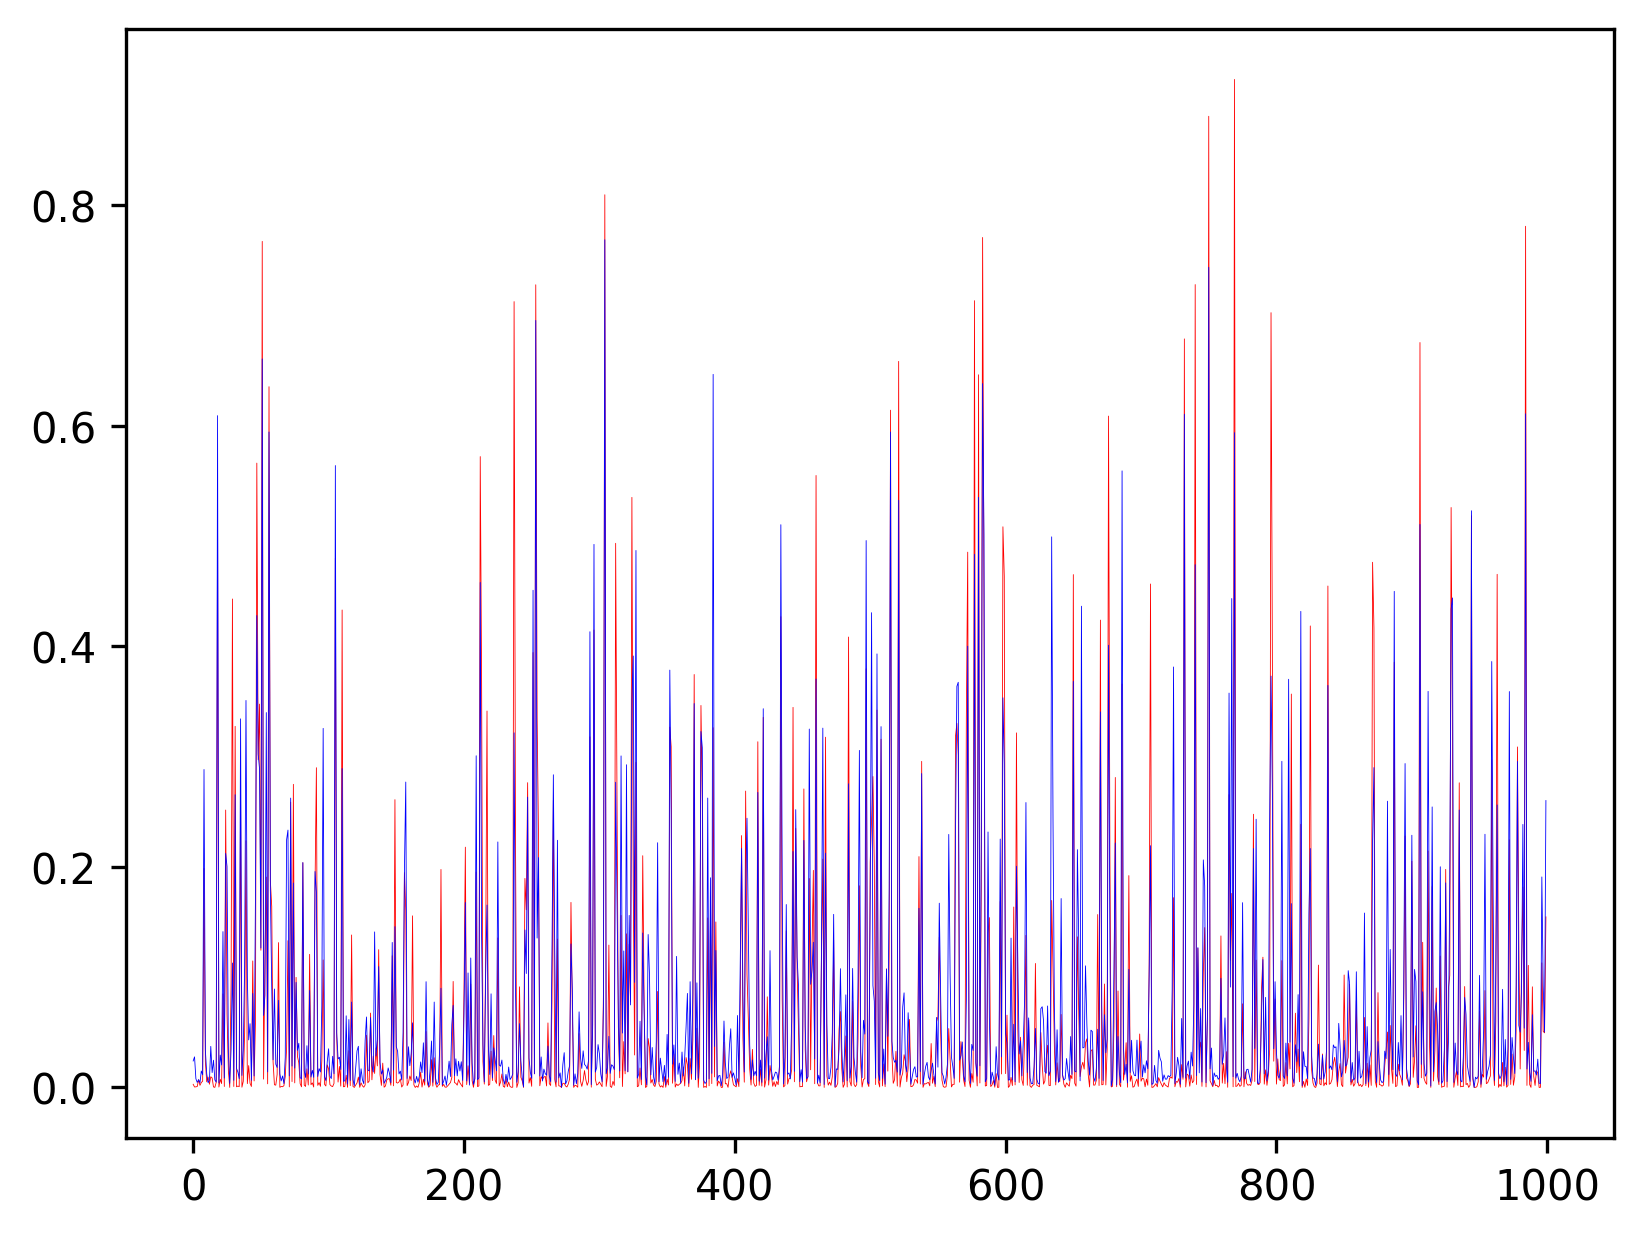

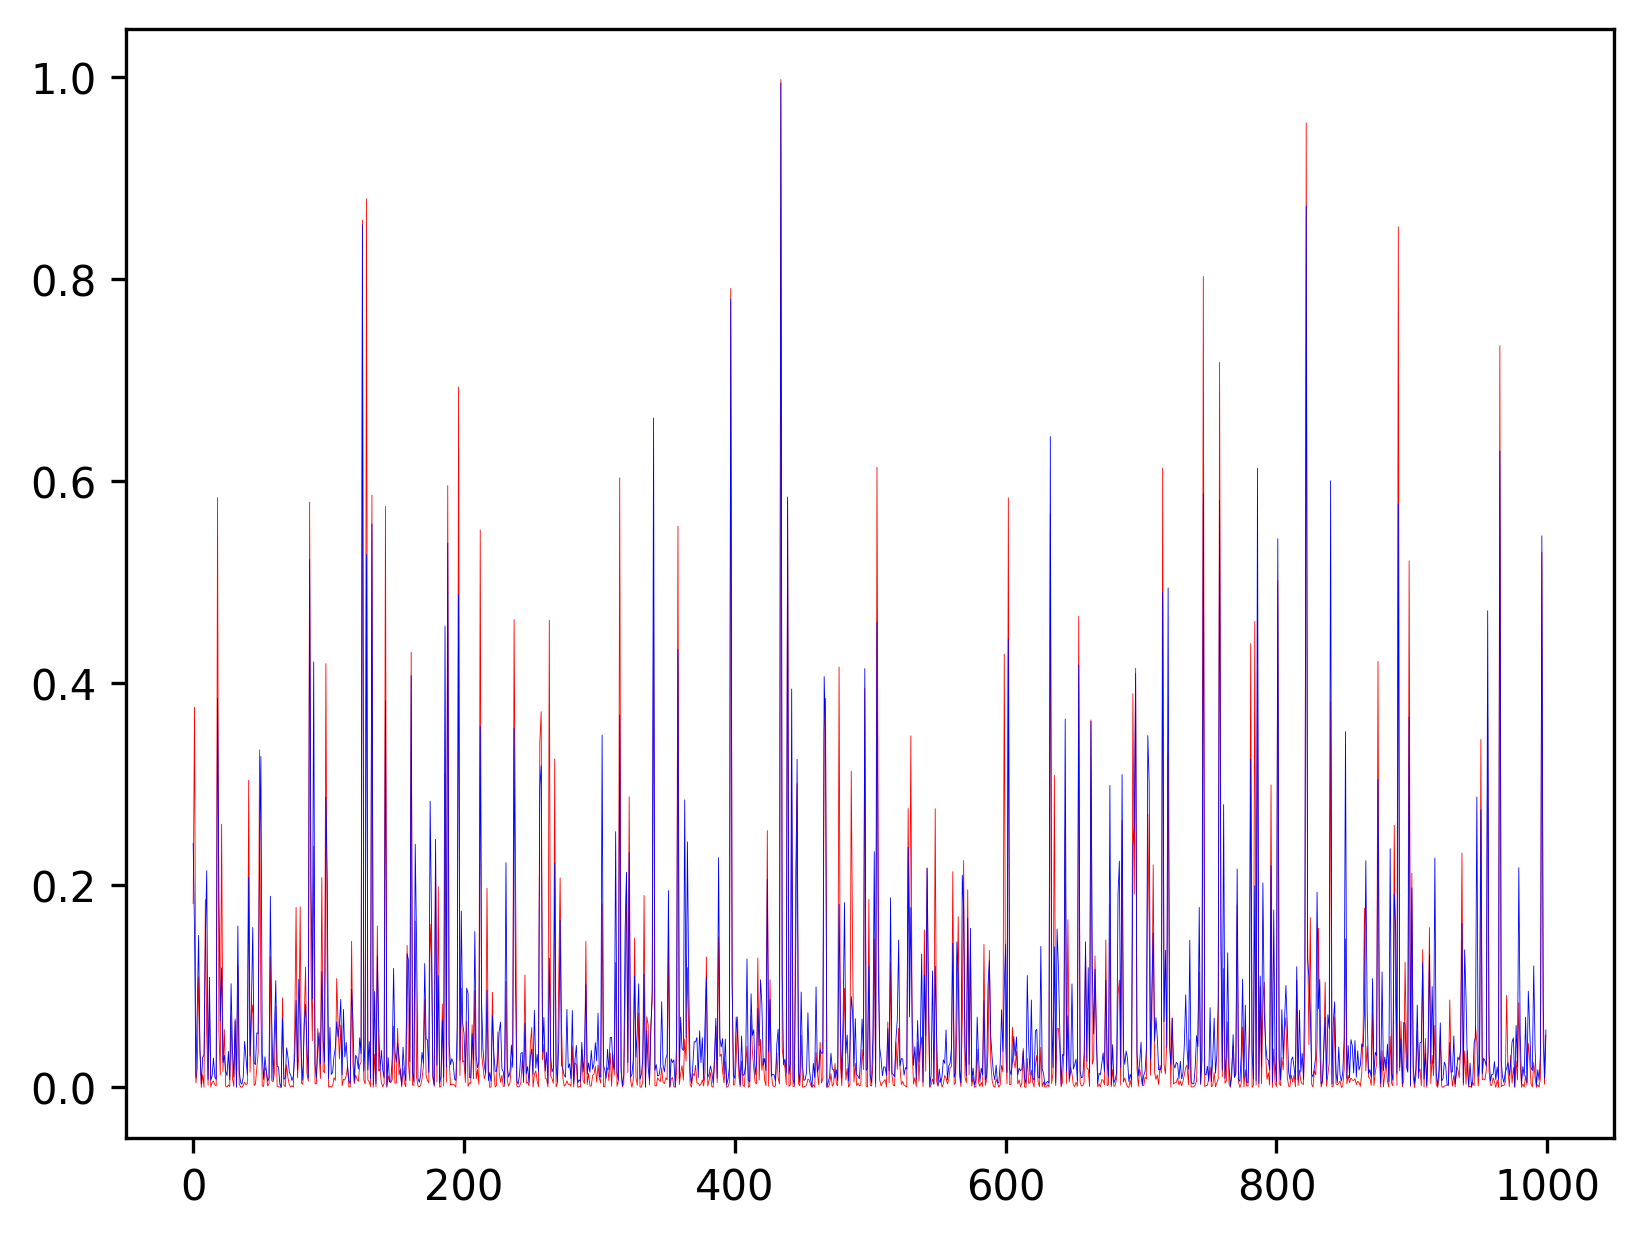

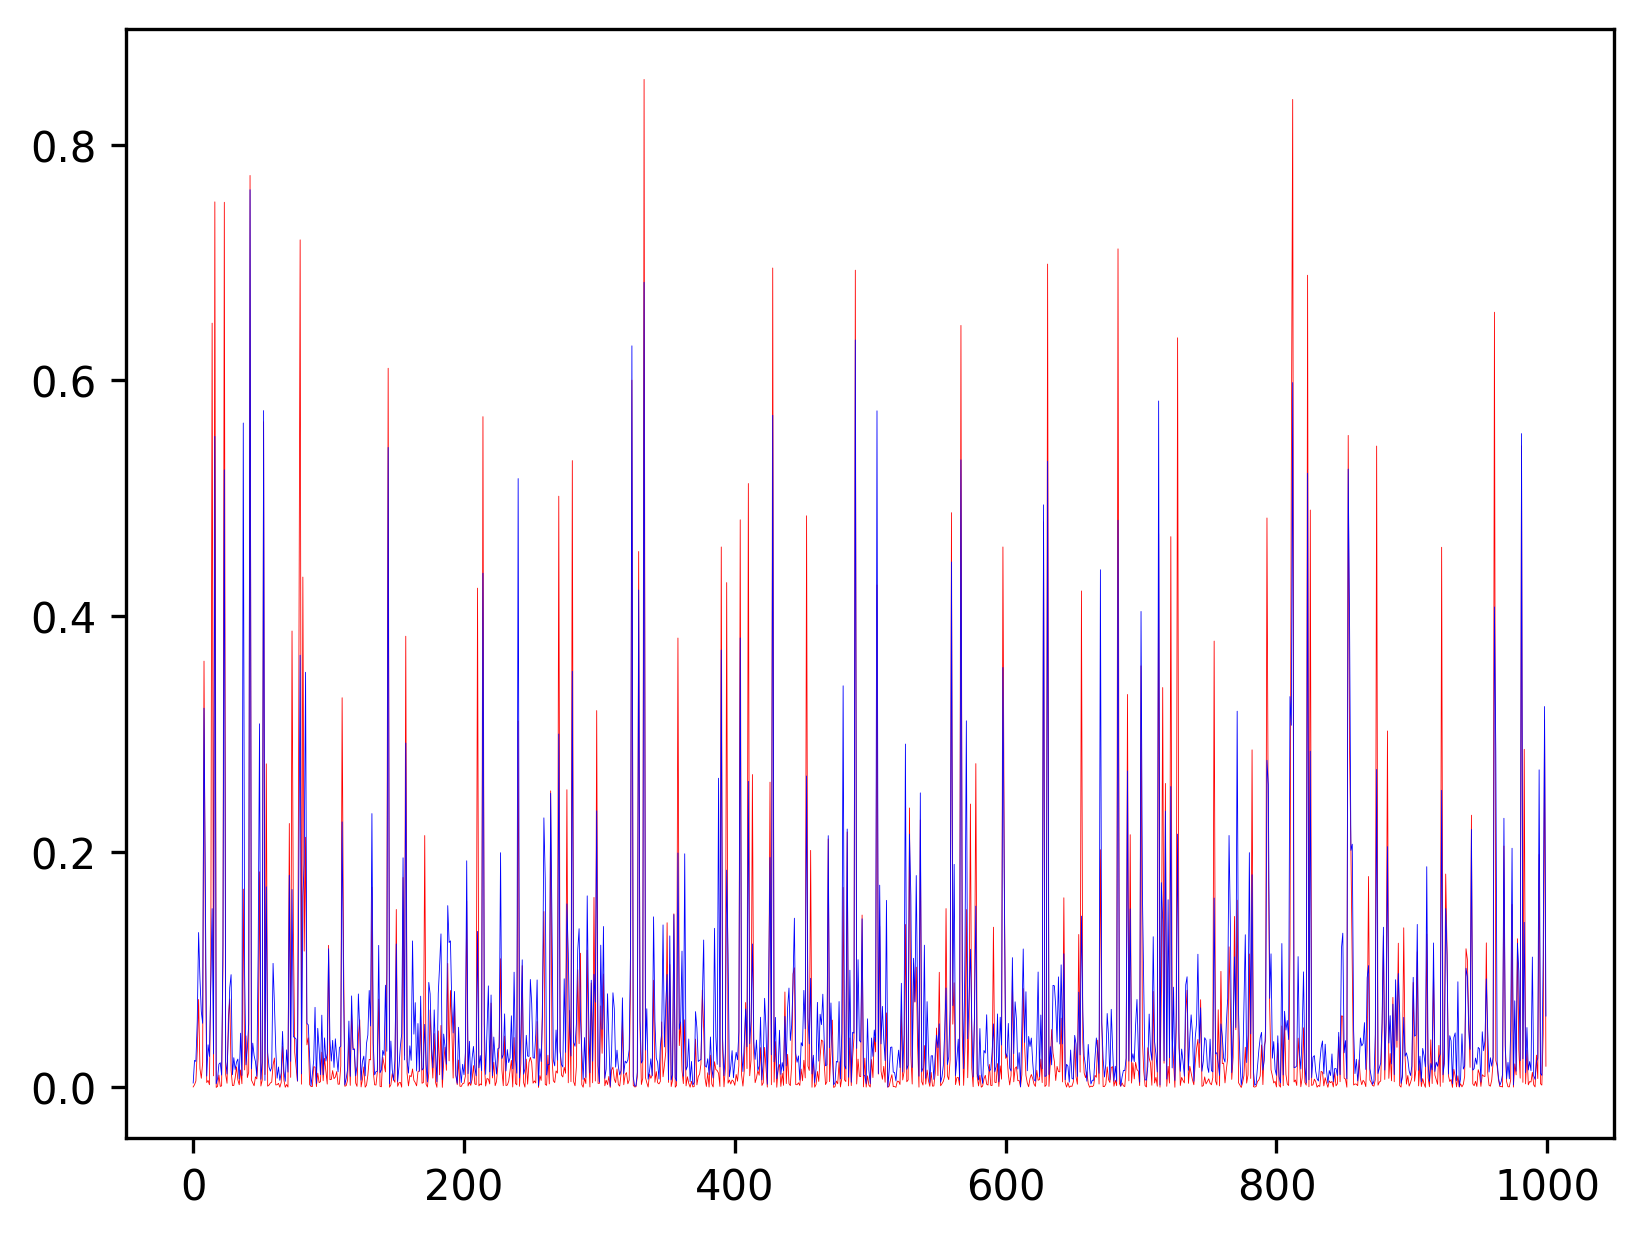

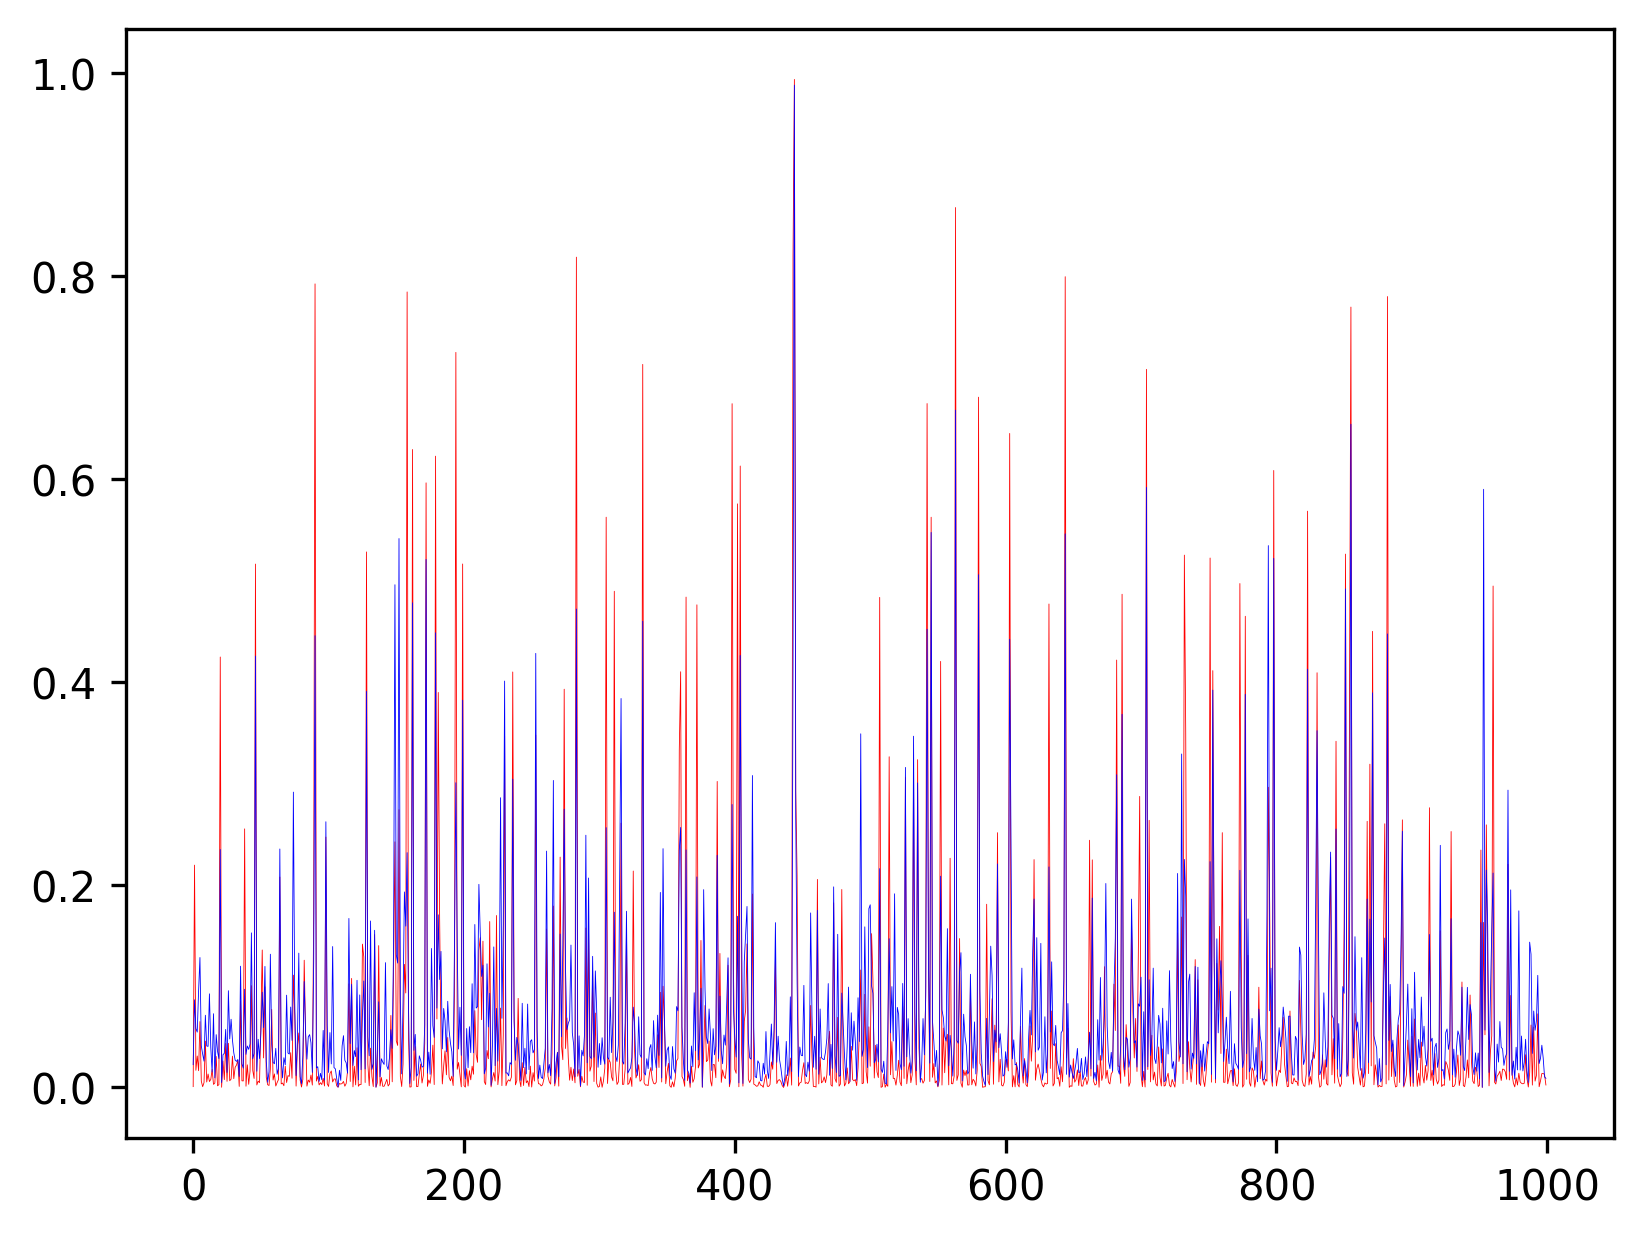

In [26]:
import matplotlib.pyplot as plt
for layer in range(len(code_counters[0])):
    plt.figure()
    subsample = 1000
    plt.plot(code_counters[0][layer][:subsample], color='red', linewidth=0.2)
    #plt.plot(code_counters[1][layer][:subsample], color='orange', linewidth=0.2)

    plt.plot(pile_counters[0][layer][:subsample], color='blue', linewidth=0.2)
    #plt.plot(pile_counters[1][layer][:subsample], color='cyan', linewidth=0.2)

In [28]:
evaluate_all( 10000 )

No config specified, defaulting to: the_pile/all
accuracy 35.7% (curr 61.0%): : 10381it [00:46, 221.83it/s]                        


pile w/ skip: 36.0% - ( 3702/10381 )
pile no skip: 46.0% - ( 7573/16445 )


Using custom data configuration codeparrot--codeparrot-clean-valid-826c6fd8b27e5523
Found cached dataset json (/config/.cache/huggingface/datasets/codeparrot___json/codeparrot--codeparrot-clean-valid-826c6fd8b27e5523/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab)


  0%|          | 0/1 [00:00<?, ?it/s]

accuracy 35.5% (curr 27.4%): : 10209it [01:49, 93.00it/s]                         

code w/ skip: 35.0% - ( 3620/10209 )
code no skip: 50.0% - ( 10818/21528 )


In [34]:
ff_criterion = ( pruned_code_counters[0] > (2*pruned_pile_counters[0]) )

print([ x.sum() for x in ff_criterion.detach().numpy() ])

opt.delete_ff_keys( ff_criterion )

[3, 26, 80, 76, 96, 97, 53, 59, 50, 55, 92]


In [39]:
evaluate_all( 10000 )

No config specified, defaulting to: the_pile/all
accuracy 31.3% (curr 54.6%): : 10381it [01:18, 131.43it/s]                        


pile w/ skip: 31.0% - ( 3249/10381 )
pile no skip: 43.0% - ( 7007/16445 )


Using custom data configuration codeparrot--codeparrot-clean-valid-826c6fd8b27e5523
Found cached dataset json (/config/.cache/huggingface/datasets/codeparrot___json/codeparrot--codeparrot-clean-valid-826c6fd8b27e5523/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab)


  0%|          | 0/1 [00:00<?, ?it/s]

accuracy 20.6% (curr 16.4%): : 10209it [01:52, 90.44it/s]                         

code w/ skip: 21.0% - ( 2108/10209 )
code no skip: 37.0% - ( 7970/21528 )


for 1e4 steps
```
pile w/ skip: 39.0% - ( 4022/10381 )
pile no skip: 49.0% - ( 8109/16445 )

code w/ skip: 43.0% - ( 4381/10209 )
code no skip: 60.0% - ( 12974/21528)
```

After 1 iteration:
```
pile w/ skip: 36.0% - ( 3702/10381 )
pile no skip: 46.0% - ( 7573/16445 )

code w/ skip: 35.0% - ( 3620/10209 )
code no skip: 50.0% - ( 10818/21528 )
```

After 3 iterations:
```
pile w/ skip: 31.0% - ( 3249/10381 )
pile no skip: 43.0% - ( 7007/16445 )

code w/ skip: 21.0% - ( 2108/10209 )
code no skip: 37.0% - ( 7970/21528 )
```